# PARAMETERS

In [1]:
SEED = 1
MODEL_PARAMETER_NAME = 'ltn'
GPU_ID = '1'

# IMPORTS

In [2]:
import sys
import os

os.environ['CUDA_VISIBLE_DEVICES'] = GPU_ID
sys.path.append(os.path.abspath(".."))       # for 'protonet_mnist_add_utils' folder
sys.path.append(os.path.abspath("../.."))    # for 'data' folder
sys.path.append(os.path.abspath("../../..")) # for 'models' and 'datasets' folders


print(sys.path)

['/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/notebooks', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python38.zip', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/lib-dynload', '', '/users-1/eleonora/.local/lib/python3.8/site-packages', '/users-1/eleonora/anaconda3/envs/r4rr/lib/python3.8/site-packages', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky', '/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation', '/users-1/eleonora/reasoning-shortcuts/IXShort']


In [3]:
import cv2
import torch
import argparse
import datetime
import importlib
import matplotlib.pyplot as plt
import setproctitle, socket, uuid
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm
from collections import Counter
from argparse import Namespace
from numpy import float32, zeros
from datasets import get_dataset
from models import get_model
from models.mnistdpl import MnistDPL
from warmup_scheduler import GradualWarmupScheduler
from datasets.utils.base_dataset import BaseDataset
from torchvision import datasets, transforms
from utils import fprint
from utils.train import train
from utils.test import test
from utils.preprocess_resnet import preprocess
from utils.conf import *
from utils.args import *
from utils.status import progress_bar
from utils.checkpoint import save_model, create_load_ckpt
from utils.dpl_loss import ADDMNIST_DPL
from utils.metrics import (
    evaluate_metrics,
    evaluate_mix,
    mean_entropy,
)
from torch.utils.data import Dataset, DataLoader, Subset, TensorDataset

from sklearn.metrics import confusion_matrix
from sklearn.metrics import silhouette_samples
from scipy.spatial.distance import cdist

from ultralytics import YOLO

from protonet_kand_modules.arguments import args_dpl, args_sl, args_ltn
from protonet_kand_modules.utility_modules.check_gpu import my_gpu_info
from protonet_kand_modules.data_modules.proto_data_creation import get_support_loader

%matplotlib inline

# SETUP

In [4]:
if MODEL_PARAMETER_NAME == 'dpl':   args = args_dpl
elif MODEL_PARAMETER_NAME == 'sl':  args = args_sl
else:                               args = args_ltn

# saving
save_folder = "kand" 
save_model_name = MODEL_PARAMETER_NAME
save_paths = []
save_path = os.path.join("..", "outputs", 
    save_folder, 
    "baseline-kandinsky-single-disj", 
    save_model_name
)
save_paths.append(save_path)
print(f"Save paths: {str(save_paths)}")

if args.model in ['prokandsl', 'prokandltn', 'prokanddpl'] or args.prototypes:
    raise ValueError("This experiment is NOT meant for pNet based models.")

Save paths: ['../outputs/kand/baseline-kandinsky-single-disj/ltn']


In [5]:
my_gpu_info()

Torch version:  1.13.0+cu117
CUDA version:  11.7
Number of GPUs available: 1
Device 0: NVIDIA TITAN Xp
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes


In [6]:
# Add uuid, timestamp and hostname for logging
args.conf_jobnum = str(uuid.uuid4())
args.conf_timestamp = str(datetime.datetime.now())
args.conf_host = socket.gethostname()
args.GPU_ID = GPU_ID

# set job name
setproctitle.setproctitle(
    "{}_{}_{}".format(
        args.model,
        args.buffer_size if "buffer_size" in args else 0,
        args.dataset,
    )
)

## Annotated Dataset Creation

### Loading the data

In [7]:
proto_images = torch.load('../data/kand_annotations/pnet_proto/concept_prototypes.pt')
proto_labels = torch.load('../data/kand_annotations/pnet_proto/labels_prototypes.pt')
print("Prototypical data loaded")
print("Images: ", proto_images.shape)
print("Labels: ", proto_labels.shape)

support_loader = get_support_loader(proto_images, proto_labels, query_batch_size=32, debug=False)

Prototypical data loaded
Images:  torch.Size([1467, 3, 64, 64])
Labels:  torch.Size([1467, 2])


### Creating the Datasets

In [8]:
class PrimitivesDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        """
        Args:
            images (Tensor): Tensor of shape [N, 3, 64, 64]
            labels (Tensor): Tensor of shape [N, 2] where:
                             - labels[:, 0] is the shape label  (0: square, 1: circle, 2: triangle)
                             - labels[:, 1] is the colour label (0: red, 1: yellow, 2: blue)
            transform: Optional transformation to apply to images.
        """
        self.images = images
        self.labels = labels  # shape [N, 2]
        self.transform = transform

    def __getitem__(self, index):
        image = self.images[index]
        # Return shape label and colour label separately
        shape_label = self.labels[index, 0].long()
        color_label = self.labels[index, 1].long()
        if self.transform:
            image = self.transform(image)
        return image, shape_label.squeeze(), color_label.squeeze()

    def __len__(self):
        return len(self.images)

### Creating the Episodes

In [9]:
from torch.utils.data import Sampler

class FixedBatchSampler(Sampler):
    def __init__(self, dataset_size, batch_size, iterations):
        self.dataset_size = dataset_size
        self.batch_size = batch_size
        self.iterations = iterations

    def __iter__(self):
        for i in range(self.iterations):
            start = (i * self.batch_size) % self.dataset_size
            end = start + self.batch_size
            if end <= self.dataset_size:
                yield list(range(start, end))
            else:
                # wrap around if needed
                part1 = list(range(start, self.dataset_size))
                part2 = list(range(0, end - self.dataset_size))
                yield part1 + part2

    def __len__(self):
        return self.iterations


In [10]:
class PrototypicalBatchSampler(object):
    """
    Yields a batch of indices for episodic training.
    At each iteration, it randomly selects 'classes_per_it' classes and then picks
    'num_samples' samples for each selected class.
    """
    def __init__(self, labels, classes_per_it, num_samples, iterations):
        """
        Args:
            labels (array-like): 1D array or list of labels for the target task.
                                 This should be either the shape labels or the colour labels.
            classes_per_it (int): Number of random classes for each iteration.
            num_samples (int): Number of samples per class (support + query) in each episode.
            iterations (int): Number of iterations (episodes) per epoch.
        """
        self.labels = np.array(labels)
        self.classes_per_it = classes_per_it
        self.sample_per_class = num_samples
        self.iterations = iterations
        
        self.classes, self.counts = np.unique(self.labels, return_counts=True)
        self.classes = torch.LongTensor(self.classes)

        # Create an index matrix of shape (num_classes, max_samples_in_class)
        max_count = max(self.counts)
        self.indexes = np.empty((len(self.classes), max_count), dtype=int)
        self.indexes.fill(-1)
        self.indexes = torch.LongTensor(self.indexes)
        self.numel_per_class = torch.zeros(len(self.classes), dtype=torch.long)

        # Fill in the matrix with indices for each class.
        for idx, label in enumerate(self.labels):
            # Find the row corresponding to this label
            class_idx = (self.classes == label).nonzero(as_tuple=False).item()
            # Find the next available column (where the value is -1)
            pos = (self.indexes[class_idx] == -1).nonzero(as_tuple=False)[0].item()
            self.indexes[class_idx, pos] = idx
            self.numel_per_class[class_idx] += 1

    def __iter__(self):
        """
        Yield a batch of indices for each episode.
        """
        spc = self.sample_per_class
        cpi = self.classes_per_it

        for _ in range(self.iterations):
            batch = torch.LongTensor(cpi * spc)
            # Randomly choose 'classes_per_it' classes
            c_idxs = torch.randperm(len(self.classes))[:cpi]
            for i, class_idx in enumerate(c_idxs):
                s = slice(i * spc, (i + 1) * spc)
                # Randomly choose 'num_samples' indices for the class
                perm = torch.randperm(self.numel_per_class[class_idx])
                sample_idxs = perm[:spc]
                batch[s] = self.indexes[class_idx, sample_idxs]
            # Shuffle the batch indices
            batch = batch[torch.randperm(len(batch))]
            yield batch

    def __len__(self):
        return self.iterations

### Istantiating the DataLoaders

In [11]:
# Create PrimitvesDataset instance
kand_proto_dataset = PrimitivesDataset(proto_images, proto_labels, transform=None)

# Extract the 1D label arrays from the dataset labels. Note: support_dataset.labels is a tensor of shape [N,2].
shape_labels = kand_proto_dataset.labels[:, 0].numpy()  # & ok
color_labels = kand_proto_dataset.labels[:, 1].numpy()  # & ok

# Create episodes sampler for shapes and colours:
shape_sampler = PrototypicalBatchSampler(shape_labels, args.classes_per_it, args.num_samples, args.iterations)
color_sampler = PrototypicalBatchSampler(color_labels, args.classes_per_it, args.num_samples, args.iterations)

# Create dataloaders for each primitve
episodic_shape_dataloader = DataLoader(kand_proto_dataset, batch_sampler=shape_sampler)
episodic_color_dataloader = DataLoader(kand_proto_dataset, batch_sampler=color_sampler)

print(f"Number of episodes (shape): {len(episodic_shape_dataloader)}")
print(f"Number of episodes (color): {len(episodic_color_dataloader)}")

Number of episodes (shape): 200
Number of episodes (color): 200


### Checking the Data

Number of distinct shape labels: 3
Number of distinct color labels: 3
Batch images shape: torch.Size([30, 3, 64, 64])
Batch shape labels: [0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 1, 0, 0, 1, 2, 1, 2, 0, 0, 1, 2, 2, 2, 2, 2, 0, 1, 0, 2, 2]
Shape label distribution in batch: Counter({0: 10, 1: 10, 2: 10})


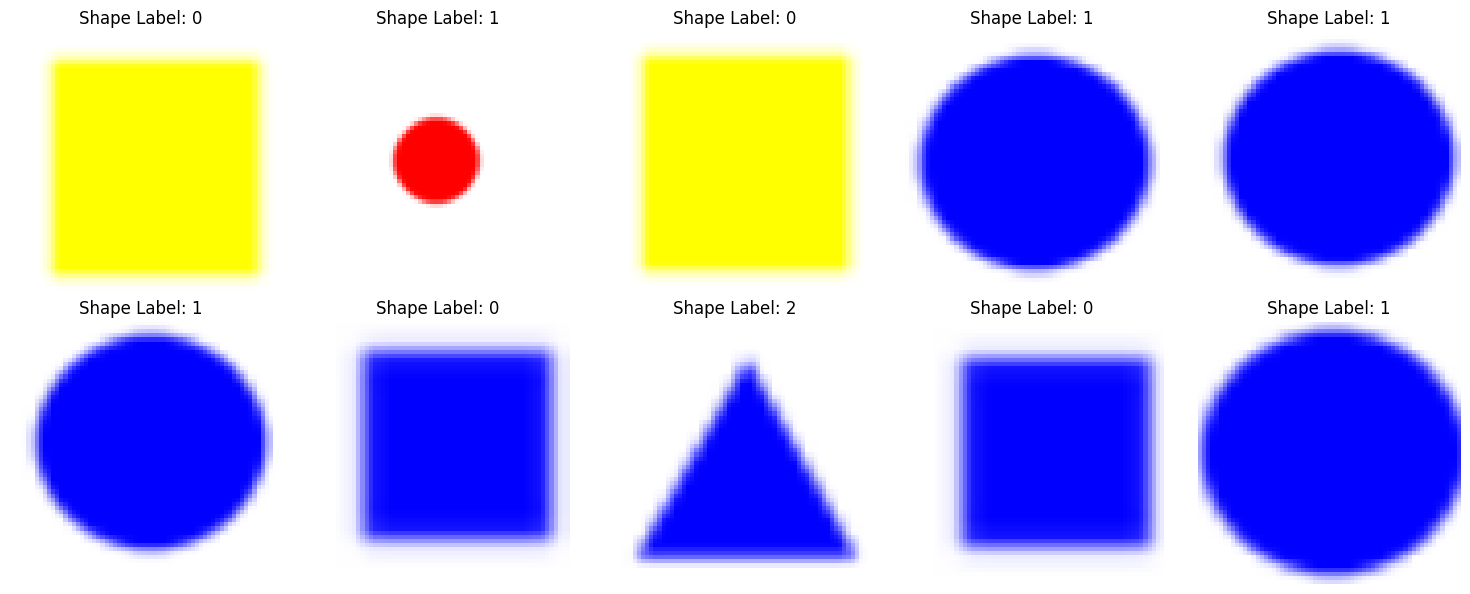


Color-based episodic batch:
Batch images shape: torch.Size([30, 3, 64, 64])
Batch color labels: [0, 1, 0, 2, 2, 0, 2, 1, 1, 2, 0, 2, 1, 1, 1, 0, 0, 1, 2, 1, 1, 2, 0, 0, 2, 2, 0, 2, 0, 1]
Color label distribution in batch: Counter({0: 10, 1: 10, 2: 10})


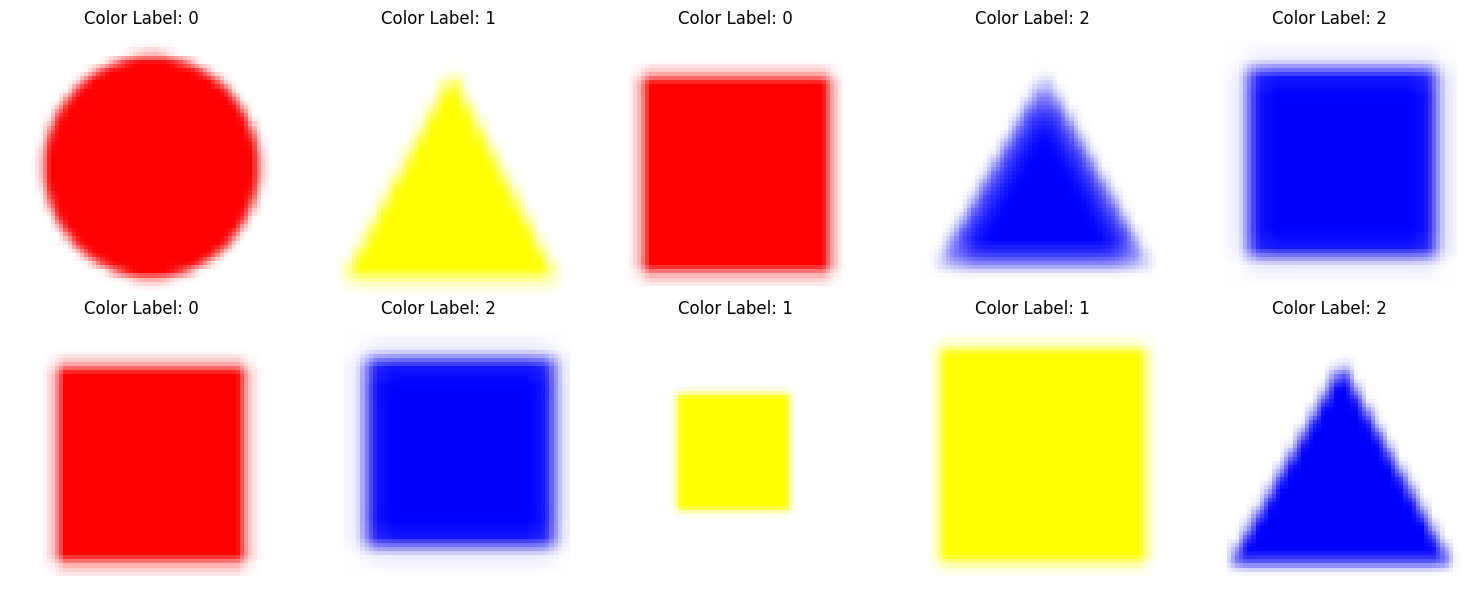

In [12]:
# Extract the 1D label arrays from the dataset labels. Note: support_dataset.labels is a tensor of shape [N,2].
num_distinct_shape_labels = np.unique(shape_labels).size

# Should have 3 labels for shapes (0: square, 1: circle, 2: triangle) and 3 labels for colours (0: red, 1: yellow, 2: blue)
print(f"Number of distinct shape labels: {num_distinct_shape_labels}")
num_distinct_color_labels = np.unique(color_labels).size
print(f"Number of distinct color labels: {num_distinct_color_labels}")

# Prototypical networks expects nunpy arrays for labels
assert isinstance(shape_labels, np.ndarray), "shape labels should be a numpy.ndarray"
assert isinstance(color_labels, np.ndarray), "color labels should be a numpy.ndarray"

# Check tensor shapes and values
assert kand_proto_dataset.images.shape == (shape_labels.size, 3, 64, 64), \
    "The shape of kand_proto_dataset.images should be (number of shape labels, 3, 64, 64)"
assert kand_proto_dataset.images.shape == (color_labels.size, 3, 64, 64), \
    "The shape of kand_proto_dataset.images should be (number of color labels, 3, 64, 64)"
assert kand_proto_dataset.labels.shape == (color_labels.size, 2), \
    "The shape of mnist_dataset.labels should be (number of shape labels, 1)"
assert kand_proto_dataset.labels.shape == (color_labels.size, 2), \
    "The shape of mnist_dataset.labels should be (number of color labels, 1)"
assert kand_proto_dataset.images.min() >= 0 and kand_proto_dataset.images.max() <= 1, \
    "The values of kand_proto_dataset.images should be between 0 and 1"
assert np.all(np.isin(shape_labels, [0, 1, 2])), "Shape labels should only contain values 0, 1, or 2"
assert np.all(np.isin(color_labels, [0, 1, 2])), "Color labels should only contain values 0, 1, or 2"    


for batch in episodic_shape_dataloader:
    images, shape_labels_batch, _ = batch
    shape_labels_list = shape_labels_batch.tolist()
    label_counts = Counter(shape_labels_list)
    print("Batch images shape:", images.shape)  # Expected: [batch_size, 3, 64, 64]
    print("Batch shape labels:", shape_labels_list)
    print("Shape label distribution in batch:", label_counts)
    break
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img = images[i].permute(1, 2, 0).numpy() # Convert tensor from (3, 64, 64) to (64, 64, 3) for display
    ax.imshow(img)
    ax.set_title(f"Shape Label: {shape_labels_list[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

### Inspect one batch from the color dataloader
print("\nColor-based episodic batch:")
for batch in episodic_color_dataloader:
    images, _, color_labels_batch = batch
    # We only need the color labels for the color network
    color_labels_list = color_labels_batch.tolist()
    label_counts = Counter(color_labels_list)
    print("Batch images shape:", images.shape)  # Expected: [batch_size, 3, 64, 64]
    print("Batch color labels:", color_labels_list)
    print("Color label distribution in batch:", label_counts)
    break
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
for i in range(10):
    ax = axes[i // 5, i % 5]
    img = images[i].permute(1, 2, 0).numpy() # Convert tensor from (3, 64, 64) to (64, 64, 3) for display
    ax.imshow(img)
    ax.set_title(f"Color Label: {color_labels_list[i]}")
    ax.axis("off")
plt.tight_layout()
plt.show()

# MODEL & UNSUPERVISED DATASET LOADING

In [13]:
dataset = get_dataset(args)
n_images, c_split = dataset.get_split()
encoder, decoder = dataset.get_backbone()
model = get_model(args, encoder, decoder, n_images, c_split)
loss = model.get_loss(args)

print("Using Dataset: ", dataset)
print("Number of images: ", n_images)
print("Using backbone: ", encoder)
print("Using Model: ", model)
print("Using Loss: ", loss)
print("Working with taks: ", args.task)

Available datasets: ['mnmath', 'xor', 'clipboia', 'shortmnist', 'restrictedmnist', 'minikandinsky', 'presddoia', 'prekandinsky', 'sddoia', 'clipkandinsky', 'addmnist', 'clipshortmnist', 'boia_original', 'boia_original_embedded', 'clipsddoia', 'boia', 'kandinsky', 'halfmnist']
kand says Namespace(GPU_ID='1', and_op='Godel', backbone='conceptizer', batch_size=64, beta=0.99, boia_model='ce', boia_ood_knowledge=False, c_sup=0.0, c_sup_ltn=0, checkin=None, checkout=False, classes_per_it=3, concept_extractor_path='ultralytics/finetuned/kand_best_100.pt', conf_host='pssr', conf_jobnum='1b297267-898b-4735-9ad8-f9b3d49b6751', conf_timestamp='2025-09-01 13:39:17.679722', count=30, dataset='kandinsky', debug=False, device=device(type='cuda'), embedding_dim=1024, entity='', entropy=False, exp_decay=0.9, extractor_training_epochs=20, gamma=0.001, imp_op='Prod', iterations=200, joint=False, lr=0.001, model='kandltnsingledisj', n_epochs=40, n_support=75, non_verbose=False, notes=None, num_distinct_la

# YOLO

In [14]:
yaml_path = os.path.join(os.getcwd(), "../data/kand_config_yolo.yaml")
my_yolo_project_path = f"ultralytics-4/"
my_yolo_premodel_path = f"ultralytics-4/pretrained/yolo11n.pt"
args.yolo_folder = my_yolo_project_path

yolo = YOLO(my_yolo_premodel_path)

# PRETRAINING

In [15]:
model.encoder

ModuleList(
  (0): SingleDisjMLP(
    (backbone): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=12288, out_features=256, bias=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Linear(in_features=128, out_features=3, bias=True)
    )
  )
  (1): SingleDisjMLP(
    (backbone): Sequential(
      (0): Flatten(start_dim=1, end_dim=-1)
      (1): Linear(in_features=12288, out_features=256, bias=True)
      (2): ReLU()
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
      (5): Linear(in_features=128, out_features=3, bias=True)
    )
  )
)

In [16]:
def evaluate_model(model, data_loader):
    model.encoder.eval()
    correct_shape = 0
    correct_color = 0
    total = 0

    with torch.no_grad():
        for images, shape_labels, color_labels in data_loader:
            images = images.to(model.device)
            shape_labels = shape_labels.to(model.device)
            color_labels = color_labels.to(model.device)

            # Forward through separate backbones
            shape_preds = model.encoder[0](images)
            color_preds = model.encoder[1](images)

            shape_pred_labels = torch.argmax(shape_preds, dim=1)
            color_pred_labels = torch.argmax(color_preds, dim=1)

            correct_shape += (shape_pred_labels == shape_labels).sum().item()
            correct_color += (color_pred_labels == color_labels).sum().item()
            total += images.size(0)

    shape_acc = correct_shape / total
    color_acc = correct_color / total
    overall_acc = (shape_acc + color_acc) / 2

    print(f"Shape Accuracy: {shape_acc:.4f}")
    print(f"Color Accuracy: {color_acc:.4f}")
    print(f"Overall Accuracy: {overall_acc:.4f}")


In [17]:
def pre_train(model, train_loader, args, seed: int = 0):
    
    # Full reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
    torch.backends.cudnn.enabled = False

    # Separate optimizers
    enc_opt = torch.optim.Adam(
        list(model.encoder[0].parameters()) + list(model.encoder[1].parameters()),
        lr=args.lr, weight_decay=args.weight_decay
    )

    fprint("\n--- Start of Training ---\n")
    model.encoder.to(model.device)
    model.encoder.train()

    shape_loss_fn = torch.nn.CrossEntropyLoss()
    color_loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(args.proto_epochs):
        for i, batch in enumerate(train_loader):
            images, shape_labels, color_labels = batch
            images = images.to(model.device)
            shape_labels = shape_labels.to(model.device)
            color_labels = color_labels.to(model.device)
            batch_size = images.size(0)

            assert images.shape == torch.Size([batch_size, 3, 64, 64]), \
                f"Expected shape [{batch_size}, 3, 64, 64], but got {images.shape}"

            enc_opt.zero_grad()

            # Forward pass through separate backbones
            shape_preds = model.encoder[0](images)
            color_preds = model.encoder[1](images)

            assert shape_preds.shape == (batch_size, 3), \
                f"Expected shape_preds ({batch_size}, 3), but got {shape_preds.shape}"
            assert color_preds.shape == (batch_size, 3), \
                f"Expected color_preds ({batch_size}, 3), but got {color_preds.shape}"

            # Compute losses
            loss_shape = shape_loss_fn(shape_preds, shape_labels)
            loss_color = color_loss_fn(color_preds, color_labels)
            loss = loss_shape + loss_color

            loss.backward()
            enc_opt.step()

            progress_bar(i, len(train_loader), epoch, loss.item())

    evaluate_model(model, train_loader)

pre_train(model, episodic_shape_dataloader, args)


--- Start of Training ---



[ 09-01 | 13:39 ] epoch 9: |██████████████████████████████████████████████████| loss: 0.00073795

Shape Accuracy: 0.9850
Color Accuracy: 1.0000
Overall Accuracy: 0.9925


# TRAINING LOOP

In [18]:
def train(model: MnistDPL,
    dataset: BaseDataset, 
    concept_extractor,
    concept_extractor_training_path,
    concept_extractor_project_path,
    transform,
    _loss: ADDMNIST_DPL,
    args,
    save_folder: str,
    patience: int = 3
    ):
    
    best_cacc = 0.0
    epochs_no_improve = 0   # for early stopping
    yolo_save_dir = None

    model.to(model.device)

    train_loader, val_loader, test_loader = dataset.get_data_loaders()
    dataset.print_stats()
    
    # Initialize optimizers and schedulers
    shape_optimizer = torch.optim.Adam(model.encoder[0].parameters())
    color_optimizer = torch.optim.Adam(model.encoder[1].parameters())
    shape_lr_scheduler = torch.optim.lr_scheduler.StepLR(shape_optimizer, step_size=10, gamma=0.5)
    color_lr_scheduler = torch.optim.lr_scheduler.StepLR(color_optimizer, step_size=10, gamma=0.5)

    fprint("\n--- Start of Training ---\n")

    # * Start of training
    for epoch in range(args.proto_epochs + 1):  # first epoch is for determining the baseline accuracy
        print(f"Epoch {epoch+1}/{args.proto_epochs + 1}")

        # ^ PHASE 1: Training the Concept Extractor
        print('----------------------------------')
        print('--- Concept Extractor Training ---')
        if epoch == 0:
            results = concept_extractor.train(data=concept_extractor_training_path, 
                        epochs=args.extractor_training_epochs, 
                        imgsz=64, 
                        project=concept_extractor_project_path)
            yolo_save_dir = os.path.join(results.save_dir, "weights", "last.pt")
        else:
            assert yolo_save_dir is not None
            concept_extractor = YOLO(yolo_save_dir)
            results = concept_extractor.train(data=concept_extractor_training_path, 
                        epochs=args.extractor_training_epochs, 
                        imgsz=64, 
                        project=concept_extractor_project_path)
            yolo_save_dir = os.path.join(results.save_dir, "weights", "last.pt")

        # ^ PHASE 2: Main Model Training
        ys, y_true, cs, cs_true = None, None, None, None
        for i, data in enumerate(train_loader):
            
            if epoch == 0:
                model.eval()
                assert not model.training, "Model should **NOT** be in training mode!"
                assert not model.encoder[0].training, "Encoder should **NOT** be in training mode!"
                assert not model.encoder[1].training, "Encoder should **NOT** be in training mode!"
            else:    
                model.train()
                shape_optimizer.zero_grad()
                color_optimizer.zero_grad()
                assert model.training, "Model should be in training mode!"
                assert model.encoder[0].training, "Shape encoder should be in training mode!"
                assert model.encoder[1].training, "Color encoder should be in training mode!"
                
            images, labels, concepts = data
            images, labels, concepts = (
                images.to(model.device),
                labels.to(model.device),
                concepts.to(model.device),
            )

            out_dict = model(images, concept_extractor, transform, args)
            out_dict.update({"LABELS": labels, "CONCEPTS": concepts})
            
            loss, losses = _loss(out_dict, args)
            loss.backward()
            
            if epoch != 0:
                shape_optimizer.step()
                color_optimizer.step()  

            if ys is None:
                ys = out_dict["YS"]
                y_true = out_dict["LABELS"]
                cs = out_dict["pCS"]
                cs_true = out_dict["CONCEPTS"]
            else:
                ys = torch.concatenate((ys, out_dict["YS"]), dim=0)
                y_true = torch.concatenate((y_true, out_dict["LABELS"]), dim=0)
                cs = torch.concatenate((cs, out_dict["pCS"]), dim=0)
                cs_true = torch.concatenate((cs_true, out_dict["CONCEPTS"]), dim=0)

            if i % 10 == 0:
                progress_bar(i, len(train_loader) - 9, epoch, loss.item())

        # Step the scheduler (if using)
        if epoch != 0:
            shape_lr_scheduler.step()
            color_lr_scheduler.step()

        if "patterns" in args.task:
            y_true = y_true[:, -1]  # it is the last one

        model.eval()
        tloss, cacc, yacc, f1 = evaluate_metrics(model, val_loader, args, concept_extractor=concept_extractor, transform=transform)

        ### LOGGING ###
        fprint("  ACC C", cacc, "  ACC Y", yacc, "F1 Y", f1)
        print()

        if not args.tuning and cacc > best_cacc:
            print("Saving...")
            # Update best F1 score
            if best_cacc == 0.0:     print("Baseline accuracy has been determined.")
            best_cacc = cacc
            epochs_no_improve = 0
                
            # Save the best model and the concept extractor
            torch.save(model.state_dict(), save_folder)
            concept_save_path = os.path.join(os.path.dirname(save_folder), f"best_{SEED}.pt")
            concept_extractor.save(concept_save_path)
            print(f"Saved best model with CACC score: {best_cacc}")
            print()
        
        elif cacc <= best_cacc:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break
    
    
    fprint("\n--- End of Training ---\n")
    return best_cacc

# RUN ALL THINGS

In [19]:
f1_scores = dict()
print(f"*** Training model with seed {SEED}")
print("Chosen device:", model.device)
if not os.path.exists(save_path): os.makedirs(save_path, exist_ok=True)
save_folder = os.path.join(save_path, f"{save_model_name}_{SEED}.pth")
print("Saving model in folder: ", save_folder)

best_cacc = train(model=model,
    dataset=dataset,
    concept_extractor=yolo,                              # yolo model
    concept_extractor_training_path=yaml_path,           # yolo training data path
    concept_extractor_project_path=my_yolo_project_path, # yolo project path
    transform=T.Resize((64, 64)),                        # resizer     
    _loss=loss,
    args=args,
    save_folder=save_folder,
)
save_model(model, args, SEED)  # save the model parameters

print(f"*** Finished training model with seed {SEED}")

print("Training finished.")
print(f"Best CACC score: {best_cacc}")

*** Training model with seed 1
Chosen device: cuda
Saving model in folder:  ../outputs/kand/baseline-kandinsky-single-disj/ltn/ltn_1.pth
Loaded datasets in 4.185626029968262 s.
Len loaders: 
 train: 4000 
 val: 1000
 len test: 1000
## Statistics ##
Train samples 4000
Validation samples 1000
Test samples 1000

--- Start of Training ---

Epoch 1/11
----------------------------------
--- Concept Extractor Training ---
New https://pypi.org/project/ultralytics/8.3.190 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/ka

train: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/train/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 10.5±5.4 MB/s, size: 0.5 KB)


val: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/val/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to ultralytics-4/train9/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to ultralytics-4/train9
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.205G      1.811      3.509      1.158         92         64: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.90it/s]

                   all         12         36       0.02      0.111     0.0118    0.00837



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.205G      1.336      3.228      1.023         86         64: 100%|██████████| 13/13 [00:01<00:00,  6.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 17.03it/s]

                   all         12         36     0.0357      0.222     0.0407     0.0213



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.205G      1.385      2.868      0.986         73         64: 100%|██████████| 13/13 [00:01<00:00,  6.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.49it/s]

                   all         12         36      0.114          1      0.141     0.0701



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.205G      1.365      2.326     0.9567         71         64: 100%|██████████| 13/13 [00:02<00:00,  6.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.91it/s]

                   all         12         36     0.0572          1      0.361      0.235



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.205G      1.329      1.794     0.9455         63         64: 100%|██████████| 13/13 [00:02<00:00,  6.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.73it/s]

                   all         12         36      0.804      0.228      0.617      0.355



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20     0.205G      1.287      1.399     0.9322         74         64: 100%|██████████| 13/13 [00:02<00:00,  6.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.20it/s]

                   all         12         36      0.956      0.601      0.961      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20     0.205G      1.289      1.137     0.9221         80         64: 100%|██████████| 13/13 [00:02<00:00,  6.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.46it/s]

                   all         12         36      0.899      0.987       0.95      0.563



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20     0.205G      1.237     0.9553     0.9226         76         64: 100%|██████████| 13/13 [00:02<00:00,  5.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.89it/s]

                   all         12         36          1      0.994      0.995      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20     0.205G      1.234     0.8487     0.9128         70         64: 100%|██████████| 13/13 [00:01<00:00,  6.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.11it/s]

                   all         12         36       0.97          1      0.985      0.759



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20     0.205G      1.124     0.7878     0.9081         77         64: 100%|██████████| 13/13 [00:02<00:00,  6.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.75it/s]

                   all         12         36      0.894          1      0.934      0.668


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20     0.205G     0.8714     0.6818     0.8772         42         64: 100%|██████████| 13/13 [00:03<00:00,  3.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.93it/s]

                   all         12         36      0.998          1      0.995      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20     0.205G     0.7456     0.6099     0.8804         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 16.15it/s]

                   all         12         36      0.999          1      0.995      0.694



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20     0.205G     0.6925      0.578     0.8797         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.00it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.59it/s]

                   all         12         36      0.999          1      0.995       0.76



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20     0.205G     0.6902     0.5765     0.8803         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.34it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.19it/s]

                   all         12         36      0.998          1      0.995      0.705



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20     0.205G     0.7179     0.5753     0.8663         42         64: 100%|██████████| 13/13 [00:02<00:00,  6.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.04it/s]

                   all         12         36      0.998          1      0.995      0.712



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20     0.205G     0.5831     0.5563     0.8729         42         64: 100%|██████████| 13/13 [00:02<00:00,  5.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.83it/s]

                   all         12         36      0.998          1      0.995      0.802



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20     0.205G     0.5919     0.5007     0.8577         42         64: 100%|██████████| 13/13 [00:01<00:00,  7.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.78it/s]

                   all         12         36      0.998          1      0.995      0.742



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20     0.205G     0.5457     0.5091      0.867         42         64: 100%|██████████| 13/13 [00:01<00:00,  7.14it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.23it/s]

                   all         12         36      0.998          1      0.995      0.807



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20     0.205G     0.5049     0.5086     0.8729         42         64: 100%|██████████| 13/13 [00:02<00:00,  5.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.00it/s]

                   all         12         36      0.998          1      0.995      0.826



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20     0.205G     0.5169     0.5044     0.8681         42         64: 100%|██████████| 13/13 [00:02<00:00,  5.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.87it/s]

                   all         12         36      0.998          1      0.995      0.794



20 epochs completed in 0.016 hours.
Optimizer stripped from ultralytics-4/train9/weights/last.pt, 5.4MB
Optimizer stripped from ultralytics-4/train9/weights/best.pt, 5.4MB

Validating ultralytics-4/train9/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:1 (NVIDIA TITAN Xp, 12190MiB)
YOLO11n summary (fused): 100 layers, 2,582,347 parameters, 0 gradients


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 15.47it/s]


                   all         12         36      0.998          1      0.995      0.821
Speed: 0.0ms preprocess, 1.7ms inference, 0.0ms loss, 0.7ms postprocess per image
Results saved to ultralytics-4/train9


[ 09-01 | 13:43 ] epoch 0: |██████████████████████████████████████████████████| loss: 0.84301722

  ACC C 88.71853298611111   ACC Y 71.69921875 F1 Y 69.12042317574543

Saving...
Baseline accuracy has been determined.
Saved best model with CACC score: 88.71853298611111

Epoch 2/11
----------------------------------
--- Concept Extractor Training ---
New https://pypi.org/project/ultralytics/8.3.190 available 😃 Update with 'pip install -U ultralytics'
Ultralytics 8.3.130 🚀 Python-3.8.20 torch-1.13.0+cu117 CUDA:0 (NVIDIA TITAN Xp, 12190MiB)
WARNING ⚠️ Upgrade to torch>=2.0.0 for deterministic training.
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/notebooks/../data/kand_config_yolo.yaml, degrees=0.0, deterministic=True, device=1, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, era

train: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/train/labels.cache... 206 images, 0 backgrounds, 0 corrupt: 100%|██████████| 206/206 [00:00<?, ?it/s]


val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 9.0±3.0 MB/s, size: 0.5 KB)


val: Scanning /users-1/eleonora/reasoning-shortcuts/IXShort/shortcut_mitigation/kandinsky/data/kand_yolo_dataset/val/labels.cache... 12 images, 0 backgrounds, 0 corrupt: 100%|██████████| 12/12 [00:00<?, ?it/s]


Plotting labels to ultralytics-4/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
Image sizes 64 train, 64 val
Using 8 dataloader workers
Logging results to ultralytics-4/train10
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20     0.281G     0.9854     0.6401     0.9101         92         64: 100%|██████████| 13/13 [00:04<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 11.98it/s]

                   all         12         36      0.998          1      0.995        0.4



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20     0.281G      1.022     0.6268     0.9121         86         64: 100%|██████████| 13/13 [00:02<00:00,  5.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.68it/s]

                   all         12         36       0.94          1      0.981       0.73



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20     0.281G     0.9516     0.5881     0.9025         73         64: 100%|██████████| 13/13 [00:02<00:00,  5.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.66it/s]

                   all         12         36      0.947      0.995      0.992      0.647



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20     0.281G      1.028     0.5699     0.8995         71         64: 100%|██████████| 13/13 [00:02<00:00,  5.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 12.97it/s]

                   all         12         36      0.994          1      0.995      0.542



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20     0.281G     0.9784     0.5636     0.8998         63         64: 100%|██████████| 13/13 [00:02<00:00,  6.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:00<00:00, 13.49it/s]

                   all         12         36      0.997          1      0.995      0.666



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/13 [00:00<?, ?it/s]


KeyboardInterrupt: 